In [4]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import cv2
import warnings
import timeit
import pytorch_lightning as pl
from tqdm.auto import tqdm
from torch import optim
from scipy.special import expit
#from pytorch_lightning.loggers import WandbLogger
from skimage import io, transform, measure
from sklearn import metrics
from config import *
from conf_demo import *
from util import *
from models import *
sns.set()
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
rc = {"figure.figsize" : (9, 7),
      "axes.spines.left" : False,
      "axes.spines.right" : False,
      "axes.spines.bottom" : False,
      "axes.spines.top" : False,
      "xtick.bottom" : True,
      "xtick.labelbottom" : True,
      "ytick.labelleft" : True,
      "ytick.left" : True,
      "axes.grid" : False}
plt.rcParams.update(rc)

In [3]:
%%time
torch.cuda.empty_cache()

# Define model object and trainer.
model = CharacteristicsClassifier(img_dir=img_dir, annotations_dir=annotations_dir, metadata_file=metadata_file, weighted_sampling=False,
                                  batch_size=batch_size, learning_rate=learning_rate)
#wandb_logger = WandbLogger(project="characteristics_classifier")
trainer = pl.Trainer(max_epochs=num_epochs, devices=1, accelerator="gpu", deterministic=True)
#trainer.tune(model)
trainer.fit(model)
#trainer.test()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name        | Type              | Params
--------------------------------------------------
0 | lossC       | BCEWithLogitsLoss | 0     
1 | lossA       | DiceLoss          | 0     
2 | base_model  | ResNet            | 23.5 M
3 | sigmoid     | Sigmoid           | 0     
4 | accuracy    | Accuracy          | 0     
5 | auroc       | AUROC             | 0     
6 | sensitivity | Recall            | 0     
7 | specificity | Specificity       | 0     
--------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 35min 31s, sys: 5min 38s, total: 41min 10s
Wall time: 43min 41s


In [5]:
def find_optimal_cutoff(target, predicted):
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf': pd.Series(tpr - (1 - fpr), index=i), 'threshold': pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf - 0).abs().argsort()[:1]]
    return roc_t['threshold'].item()

# Val predictions
result_val = get_char_predictions(trainer, model, split='val', threshold=-0.3)

preds = []
for idx, row in result_val.iterrows():
    if (row[mel_class_labels_pred] == 1).sum() > 1:
        preds.append(1)
    else:
        preds.append(0)
result_val['prediction'] = preds

print('Validation:')
print('balanced acc: ', metrics.balanced_accuracy_score(result_val['benign_malignant'], result_val['prediction']).round(5))
print('sensitivity: ', metrics.recall_score(result_val['benign_malignant'], result_val['prediction']).round(5))
print('specificity: ', metrics.recall_score(result_val['benign_malignant'], result_val['prediction'], pos_label=0).round(5))

thresholds = []
for col in char_class_labels:
    threshold = find_optimal_cutoff(result_val[col], result_val[col+'_score'])
    thresholds.append(threshold)
thresholds = torch.tensor(thresholds)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 83it [00:00, ?it/s]

Validation:
balanced acc:  0.82045
sensitivity:  0.77907
specificity:  0.86183


In [6]:
# Test predictions
result_test = get_char_predictions(trainer, model, split='test', threshold=thresholds)

print('Test:')
preds = []
for idx, row in result_test.iterrows():
    if (row[mel_class_labels_pred] == 1).sum() > 1:
        preds.append(1)
    else:
        preds.append(0)
result_test['prediction'] = preds
print('balanced acc: ', metrics.balanced_accuracy_score(result_test['benign_malignant'], result_test['prediction']).round(5))
print('sensitivity: ', metrics.recall_score(result_test['benign_malignant'], result_test['prediction']).round(5))
print('specificity: ', metrics.recall_score(result_test['benign_malignant'], result_test['prediction'], pos_label=0).round(5))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 83it [00:00, ?it/s]

Test:
balanced acc:  0.81
sensitivity:  0.76
specificity:  0.86


In [5]:
trainer.save_checkpoint("model.ckpt")

In [6]:
def temperature_scale(temperature, logits):
    temp = temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
    return logits / temp

def eval():
    optimizer.zero_grad()
    loss = criterion(temperature_scale(temperature, logits), labels)
    loss.backward()
    return loss

temperature_dict = {}
for i, col in enumerate(char_class_labels):
    labels = torch.tensor(result_val[col].values).float().unsqueeze(0)
    logits = torch.tensor(result_val[col+'_score'].values).float().unsqueeze(0)
    criterion = nn.BCEWithLogitsLoss()
    #before_temperature_ce = criterion(logits, labels)
    
    temperature = nn.Parameter(torch.ones(1) * 1.5)
    optimizer = optim.LBFGS([temperature], lr=0.01, max_iter=50)

    optimizer.step(eval)
    
    temperature_dict[char_labels_full[i]] = temperature.item()



NameError: name 'char_labels_full' is not defined

# Working Example
### Set the image_id variable. Some images are provided in the images directory. 
### Run the following cell to display the image.
### Run the cell after that to display the explanations for the image.

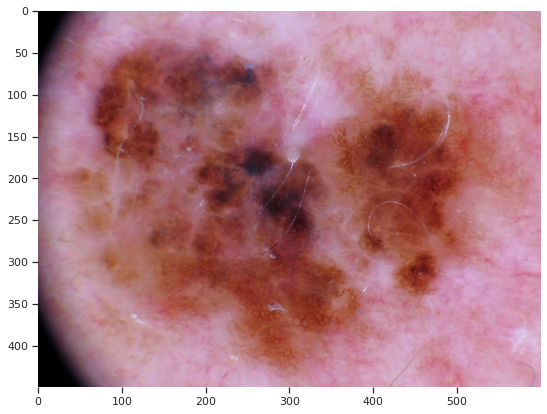

In [37]:
IMAGE_ID = 'ISIC_0026086'

raw_img = io.imread(os.path.join('images', IMAGE_ID+'.jpg'))
plt.imshow(raw_img)

ISIC_0026086
CPU times: user 28.7 s, sys: 293 ms, total: 29 s
Wall time: 1.19 s


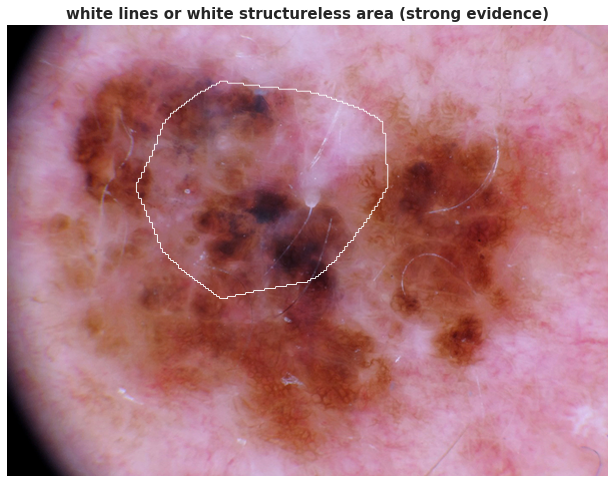

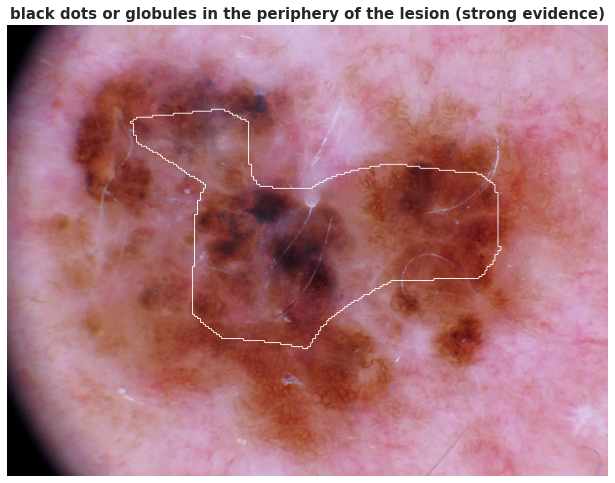

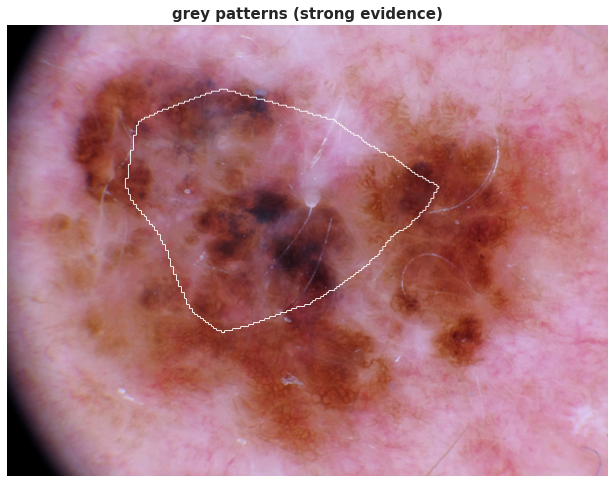

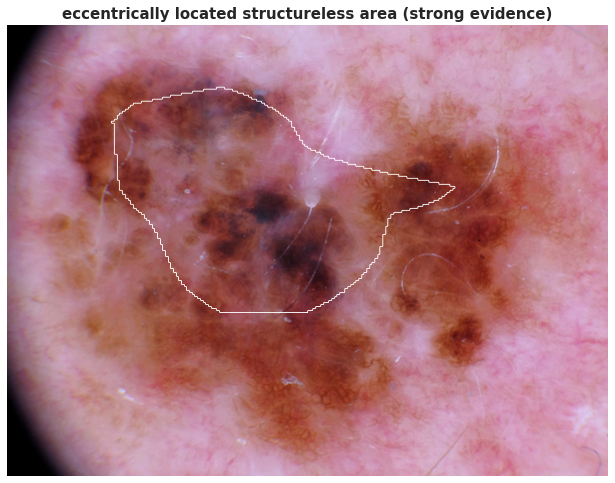

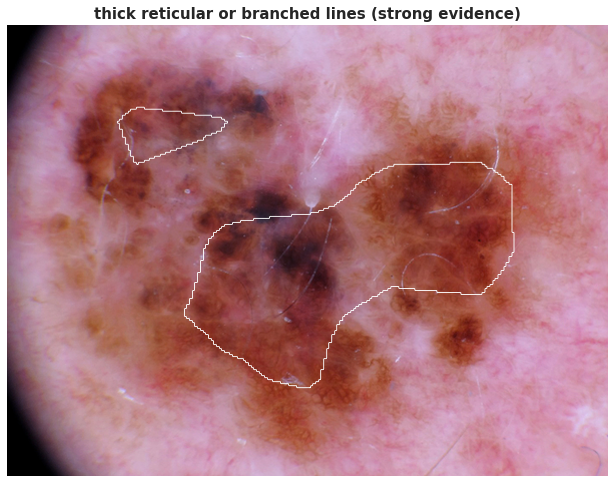

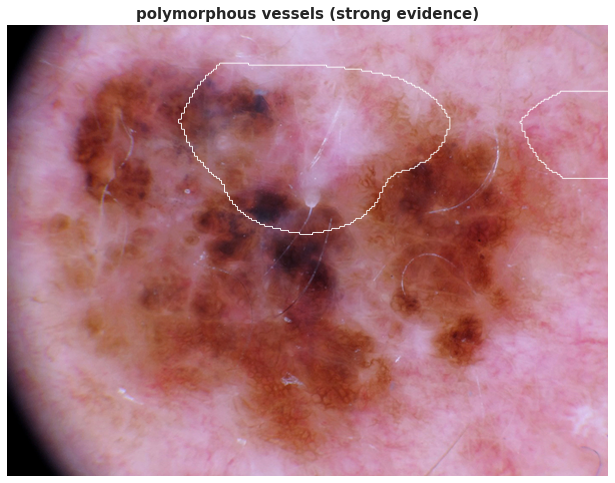

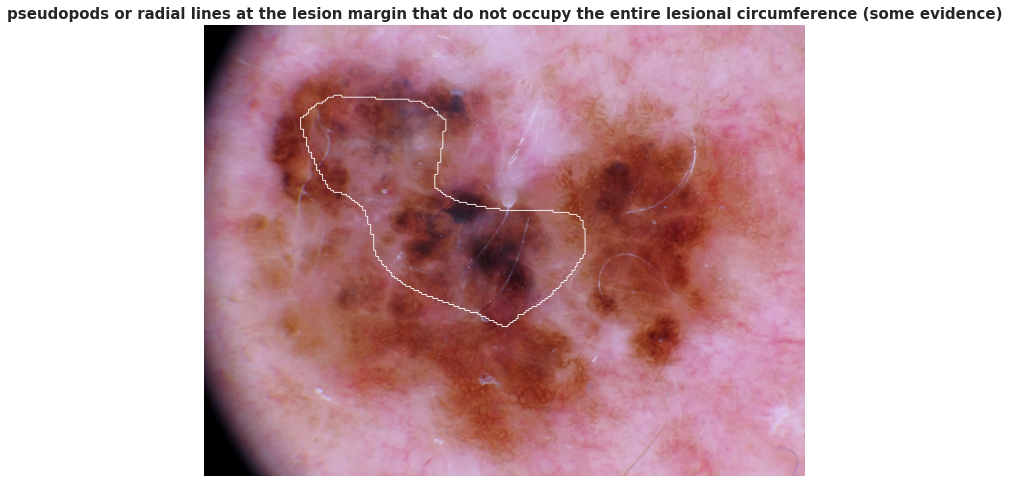

In [38]:
%%time
def forward(x):
    output = model.base_model(x)
    attributions = torch.cat([model.attribute(output, class_idx) for class_idx in range(model.num_classes)], dim=1)
    attributions = F.interpolate(attributions, size=(image_size, image_size), mode='bilinear')
    return output, attributions
    
prediction_dfs = []
result_test = pd.DataFrame({'image_id': [IMAGE_ID]})
for idx, row in result_test.iterrows():
    # Read the image
    raw_img = io.imread(os.path.join(img_dir, row.image_id+'.jpg'))
    # Transform the image (resize, normalize) and get prediction and attributions
    img = model.test_transform(image=raw_img, mask=raw_img)['image'].unsqueeze(0)
    output, attributions = forward(img)

    # Change the shapes of the attributions and logits tensors
    attributions = attributions.squeeze(0).detach().numpy()
    output = output.squeeze(0)
    # Get binary array of predicted labels for the current image
    prediction = (output >= thresholds).numpy()
    
    prediction_df = pd.DataFrame(zip(char_labels_full, prediction, output.detach().numpy()), columns=['label', 'prediction', 'output'])#[prediction]
    prediction_df['image_id'] = row.image_id
    prediction_df = prediction_df[prediction_df['prediction'] == True]
    # Temp scale and apply sigmoid
    prediction_df['output'] = prediction_df.apply(lambda row: expit(
        row['output'] / temperature_dict[row['label']]
    ), axis=1)
    
    # Calculate confidence defined by percentiles
    prediction_df['confidence'] = prediction_df.apply(lambda row: 'strong' if row['output'] >= 0.7
                                                      else ('low' if row['output']<0.5
                                                           else 'some'), axis=1)
    #prediction_df.sort_values('confidence', ascending=False, inplace=True)
    prediction_df.sort_values('output', ascending=False, inplace=True)
    
    prediction_dfs.append(prediction_df)
    
    for i in range(prediction_df.shape[0]):
        # Resize the unnormalized image for plotting
        image = transform.resize(raw_img, (450, 600))
        
        exp = prediction_df.iloc[i].label
        attr_idx = prediction_df.iloc[i].name
        conf = prediction_df.iloc[i].confidence
                
        attr_non_zero = attributions[attr_idx][attributions[attr_idx]>0.]
        if len(attr_non_zero) == 0:
            perc = 0
        else:
            perc = (np.percentile(attr_non_zero, 80))
        attr = (attributions[attr_idx] >= perc)

        attr = transform.resize(attr, (450, 600))


        image = np.clip(image, 0, 1)
        contours = measure.find_contours(attr)
        
        fig, ax = plt.subplots()
        ax.imshow(image)

        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=0.9, color='white')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(exp+" ("+str(conf)+" evidence)", fontsize=15, fontweight='bold', loc='center', wrap=True)
        fig.tight_layout()
        fig.subplots_adjust(top=0.92)

        #plt.clf()
        #plt.close(fig)        
    print(row.image_id)
prediction_df_all = pd.concat(prediction_dfs)

# Transparency Quantification

In [90]:
%%time
def forward(x):
    output = model.base_model(x)
    attributions = torch.cat([model.attribute(output, class_idx) for class_idx in range(model.num_classes)], dim=1)
    attributions = F.interpolate(attributions, size=(image_size, image_size), mode='bilinear')
    return output, attributions
count = 0
output_scores_dict = {}
test_set = pd.read_csv(metadata_file)
test_set = test_set[test_set.split=='test']

fidelity_dict = {}
for percentile in tqdm(range(5, 100, 5)):
    for idx, row in test_set.iterrows():
        # Read the image
        raw_img = io.imread(os.path.join(img_dir, row.image_id+'.jpg'))
        # Transform the image (resize, normalize) and get prediction and attributions
        img = model.test_transform(image=raw_img, mask=raw_img)['image'].unsqueeze(0)
        output, attributions = forward(img)

        # Change the shapes of the attributions and logits tensors
        attributions = attributions.squeeze(0).detach().numpy()
        output = output.squeeze(0)
        # Get binary array of predicted labels for the current image
        prediction = (output >= thresholds).numpy()

        if prediction[0:7].sum() > 1:
            prediction[7:] = False
        else:
            prediction[0:7] = False
            
        
        output_score = output[prediction].detach().numpy()
        
        # Sum all the predicted dimensions in attributions to create a global saliency map
        attributions = np.sum(attributions[prediction], axis=0)

        attr_non_zero = attributions[attributions>0.]
        if len(attr_non_zero) == 0:
            perc = 0
        else:
            perc = (np.percentile(attr_non_zero, percentile))
        attr = (attributions >= perc).copy()


        # Set the non zero pixels to 1
        attr[attr > 0] = 1
        # Flip the pixels so that the non important areas are 1s and important areas are 0s
        #attr = attr.astype(int) ^ np.ones_like(attr.astype(int))

        # Reshape to same size as img
        attr = attr[np.newaxis, np.newaxis, ...]


        new_img = img.clone()
        shape = img[0,0,:,:][attr[0]==1].shape[0]
        new_img[0,0,:,:][attr[0]==1] = torch.tensor(np.random.choice(img.flatten(), size=shape)).float()
        new_img[0,1,:,:][attr[0]==1] = torch.tensor(np.random.choice(img.flatten(), size=shape)).float()
        new_img[0,2,:,:][attr[0]==1] = torch.tensor(np.random.choice(img.flatten(), size=shape)).float()


        # Occlude the img and set to new_img
        #new_img = (img * attr).to(torch.float32).detach()

        new_output, new_attributions = forward(new_img)
        new_attributions = new_attributions.squeeze(0).detach().numpy()
        new_output = new_output.squeeze(0)
        new_prediction = (new_output >= thresholds).numpy()

        new_output_score = new_output[prediction].detach().numpy()

        output_score = expit(output_score)
        new_output_score = expit(new_output_score)

        output_scores_dict[row.image_id] = [output_score, new_output_score]        
        #print([output_score, new_output_score])

    output_changes_dict = {}
    for key, val in output_scores_dict.items():
        try:
            #output_changes_dict[key] = np.max(np.abs(val[0] - val[1]))
            
            output_changes_dict[key] = np.mean(np.sort(np.abs(val[0] - val[1]))[-2:])
        except:
            pass
    fidelity = np.array(list(output_changes_dict.values()))
    fidelity_dict[percentile] = fidelity

  0%|          | 0/19 [00:00<?, ?it/s]

CPU times: user 6h 34min 5s, sys: 6.08 s, total: 6h 34min 11s
Wall time: 6h 34min 4s


In [91]:
dfs = []
for percentile in fidelity_dict.keys():
    df = pd.DataFrame(fidelity_dict[percentile], columns=['Fidelity'])
    df['Threshold'] = percentile
    dfs.append(df)
fidelity_df = pd.concat(dfs)

In [93]:
fidelity_df.to_csv('data/classifier/fidelity.csv', index=False)